# Read raw continuous data from an SDS archive

https://docs.obspy.org/packages/autogen/obspy.clients.filesystem.sds.html#module-obspy.clients.filesystem.sds

In [ ]:
import sys
from pathlib import Path
import obspy
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
import tools
SDS_DIR = Path.cwd().parents[1].joinpath('data','continuous','SDS')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

# Show SDS_DIR
print('Tree listing of SDS_DIR directory')
for line in tools.tree(Path.cwd().joinpath(SDS_DIR)):
    print(line)

# Set start time
stime = obspy.UTCDateTime("2003196T")
print(stime)

# Get a list of NSLCs
print(sdsclient.get_all_nslc(datetime=stime))

In [ ]:
# Get and plot data
seconds = 3600
st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+seconds)
st.plot(equal_scale=False);

# Remove bad waveforms

In [ ]:
st.remove(st.select(id='MV.MBLY..BHZ')[0])
st.remove(st.select(id='MV.MBGB..BHZ')[0])
st.plot(equal_scale=False);

# Run STA/LTA Detector on a single channel

In [ ]:
# Detection
import numpy as np
from obspy.signal.trigger import plot_trigger, classic_sta_lta, recursive_sta_lta

st2 = st.copy()

tr_index = -1

Fs = int(np.round(st[tr_index].stats.sampling_rate, 0))
print(f"sampling_rate={Fs}")

sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')
st2.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
sta_samples = int(sta_secs * Fs)
lta_samples = int(lta_secs * Fs)

#cft = recursive_sta_lta(st2[tr_index].data, sta_samples, lta_samples )
cft = classic_sta_lta(st2[tr_index].data, sta_samples, lta_samples )

plot_trigger(st2[tr_index], cft, threshON, threshOFF)

# Run STA/LTA on whole Stream object (network trigger)

In [ ]:
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

threshStations = 3
max_secs = 120.0

#staltamethod = "recstalta"
#staltamethod = 'carlstatrig'
staltamethod = 'classicstalta'
trig = coincidence_trigger(staltamethod, threshON , threshOFF, st2, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)

for i, this_trig in enumerate(trig):
    print('\n',f'Event {i}')
    pprint(this_trig)

# Convert triggers to events and store in a (VolcanoSeismic)Catalog object

In [ ]:
pretrig = 20 #lta_secs * 2
posttrig = 40 # lta_secs * 2   
sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')
catalogObj = tools.triggers2volcanoseismiccatalog(trig, staltamethod, threshON, threshOFF, \
                                                  sta_secs, lta_secs, max_secs, stream=st2, pretrig=pretrig, posttrig=posttrig )
    
print(catalogObj)
dir(catalogObj)
#cat.get_times()
catalogObj.plot_eventrate()
catalogObj.plot_streams()
        

So we have the basic ability to detect events. Probably not very well. But then we could run it on multiple days of data and create a multi-day catalog. Then try running a simple event classifier on it, based on RSAM ratios or spectral metrics or full-blown ML features.

In [ ]:
dir(catalogObj)

# Run coincidence trigger on multiple days, and append catalogs

2003-07-11T00:00:00.000000Z
2003-07-11T01:00:00.000000Z
2003-07-11T02:00:00.000000Z
2003-07-11T03:00:00.000000Z
2003-07-11T04:00:00.000000Z
2003-07-11T05:00:00.000000Z
2003-07-11T06:00:00.000000Z
2003-07-11T07:00:00.000000Z
2003-07-11T08:00:00.000000Z
2003-07-11T09:00:00.000000Z
2003-07-11T10:00:00.000000Z
2003-07-11T11:00:00.000000Z
2003-07-11T12:00:00.000000Z
2003-07-11T13:00:00.000000Z
2003-07-11T14:00:00.000000Z
2003-07-11T15:00:00.000000Z
2003-07-11T16:00:00.000000Z
2003-07-11T17:00:00.000000Z
2003-07-11T18:00:00.000000Z
2003-07-11T19:00:00.000000Z
2003-07-11T20:00:00.000000Z
2003-07-11T21:00:00.000000Z
2003-07-11T22:00:00.000000Z
2003-07-11T23:00:00.000000Z
0 2003-07-11T23:40:24.226667Z
1 2003-07-11T23:41:04.400000Z
2 2003-07-11T23:41:42.280000Z
3 2003-07-11T23:42:19.813333Z
4 2003-07-11T23:42:58.626667Z
5 2003-07-11T23:43:36.120000Z
6 2003-07-11T23:44:16.680000Z
7 2003-07-11T23:44:52.400000Z
8 2003-07-11T23:45:31.200000Z
9 2003-07-11T23:46:06.066667Z
10 2003-07-11T23:46:46.77333

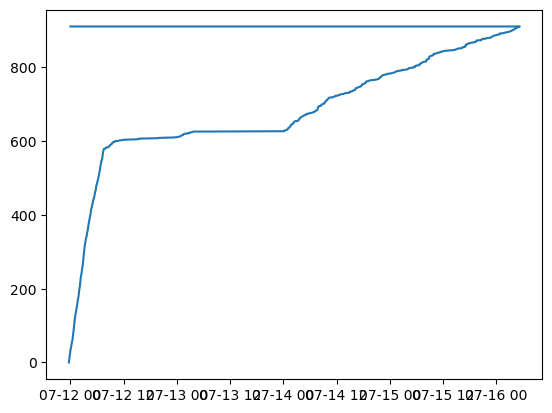

In [3]:
import sys
from pprint import pprint 
from pathlib import Path
import obspy
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
import tools
SDS_DIR = Path.cwd().parents[1].joinpath('data','continuous','SDS')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

from obspy.signal.trigger import coincidence_trigger

# set parameters
threshStations = 3 # minimum number of stations that must trigger for a coincidence trigger to occur
max_secs = 120.0
staltamethod = 'classicstalta'
sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')

pretrig = 20 #lta_secs * 2
posttrig = 40 # lta_secs * 2   

catalog_all = None

for jday in range(192, 198, 1): # Loop over days in SDS archive

    for hour in range(24):

        # set start time
        stime = obspy.UTCDateTime(f"2003{jday}T") + hour * 3600
        print(stime)
    
        # Get and plot data
        st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+3600)
        if len(st)==0:
            continue
    
        # remove bad channels, including those with insufficient samples
        for tr in st:
            if tr.stats.station == 'MBLY' or tr.stats.station == 'MBGB' or tr.stats.npts < max_secs * tr.stats.sampling_rate:
                st.remove(tr)

        if len(st)==0:
            continue
    
        # bandpass filter
        st.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
    
        # run coincidence trigger for this day
        trig = coincidence_trigger(staltamethod, threshON , threshOFF, st, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)
        if len(trig)==0:
            continue
        #pprint(trig)
        for i, this_trig in enumerate(trig):
            print(i, this_trig['time'])
            
        # create catalog object
        catalogObj = tools.triggers2volcanoseismiccatalog(trig, staltamethod, threshON, threshOFF, \
                                                      sta_secs, lta_secs, max_secs, stream=st, pretrig=pretrig, posttrig=posttrig )
    
        # Was getting crashes, so let's just save the event streams to miniseed, and then erase them
        catalogObj.write_events()
        catalogObj.streams = []
    
        # concatenate catalogs
        if catalog_all:
            catalog_all.concat(catalogObj)
        else:
            catalog_all = catalogObj

print(catalog_all)
catalog_all.plot_eventrate()
catalog_all.write_events('catalog.xml')


In [ ]:
# goal now is to steal code to plot eventrate & energy rate & eventually sausage plot

In [ ]:
# also swarm alarm system